In [1]:
import sqlalchemy
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score
import shap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from datetime import datetime
import pytz
from tqdm import tqdm
import pickle
import random


In [2]:
df = pd.read_csv("Bulk_Carrier_202001_202006.csv")
df

TIME_STAMP   ROLL  PITCH  SPEED_VG  SPEED_LG  SPEED_TG  \
0      2020-01-01T00:00:00.000Z -0.246  0.097    11.513    11.513     0.007   
1      2020-01-01T00:10:00.000Z -0.256  0.097    11.470    11.470    -0.055   
2      2020-01-01T00:20:00.000Z -0.225  0.104    11.450    11.450    -0.087   
3      2020-01-01T00:30:00.000Z -0.249  0.103    11.856    11.849    -0.160   
4      2020-01-01T00:40:00.000Z -0.224  0.088    12.438    12.438    -0.142   
...                         ...    ...    ...       ...       ...       ...   
24849  2020-06-30T23:10:00.000Z -0.463  0.451    15.888    15.898    -0.033   
24850  2020-06-30T23:20:00.000Z -0.492  0.445    15.873    15.870    -0.327   
24851  2020-06-30T23:30:00.000Z -0.580  0.451    15.890    15.895    -0.243   
24852  2020-06-30T23:40:00.000Z -0.563  0.421    15.938    15.937    -0.360   
24853  2020-06-30T23:50:00.000Z -0.513  0.443    16.060    16.050    -0.547   

       SPEED_LW  REL_WIND_SPEED  REL_WIND_DIR  COURSE_OVER_GROUND  ...  \
0        11.673          19.029         1.803              25.978  ...   
1        11.707          19.072         1.200              26.935  ...   
2        11.670          17.873         0.867              27.317  ...   
3        12.011          18.446         0.328              26.942  ...   
4        12.464          18.939         1.746              25.256  ...   
...         ...             ...           ...                 ...  ...   
24849    15.430           1.989       307.067             301.777  ...   
24850    15.510           1.384       343.003             300.927  ...   
24851    15.441           1.114        37.241             301.364  ...   
24852    15.340           0.754        15.134             300.683  ...   
24853    15.387           0.858       340.479             300.733  ...   

       SEA_SURFACE_SALINITY  SEA_SURFACE_TEMP  CURRENT_UV  CURRENT_VV  \
0                     33.29             27.10        0.04        0.07   
1                     33.28             27.11        0.05        0.08   
2                     33.28             27.10        0.05        0.08   
3                     33.28             27.10        0.06        0.09   
4                     33.28             27.09        0.06        0.09   
...                     ...               ...         ...         ...   
24849                 36.29             21.81       -0.17        0.01   
24850                 36.30             21.82       -0.17        0.01   
24851                 36.30             21.87       -0.18       -0.01   
24852                 36.31             21.90       -0.18       -0.03   
24853                 36.31             21.91       -0.18       -0.03   

       CURRENT_SPEED  CURRENT_DIRECTION  CURRENT_SPEED_SHIP_HEADING  BN  \
0               0.08             211.15                       -0.08   5   
1               0.09             210.94                       -0.09   5   
2               0.10             211.53                       -0.10   5   
3               0.10             213.21                       -0.10   5   
4               0.11             214.34                       -0.11   5   
...              ...                ...                         ...  ..   
24849           0.17              94.34                       -0.15   4   
24850           0.17              92.72                       -0.15   4   
24851           0.18              85.91                       -0.15   4   
24852           0.18              81.38                       -0.14   4   
24853           0.19              79.71                       -0.14   4   

           lat       lon  
0       3.8683  108.9862  
1       3.8977  109.0008  
2       3.9120  109.0083  
3       3.9558  109.0307  
4       3.9867  109.0453  
...        ...       ...  
24849 -21.8905   -5.8208  
24850 -21.8797   -5.8402  
24851 -21.8452   -5.9013  
24852 -21.8212   -5.9437  
24853 -21.8103   -5.9628  

[24854 rows x 193 columns]

In [3]:
# datetime으로 시계열 변환
df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP']).dt.tz_localize(None)

# full dataset
dff = df.copy()

In [4]:
me1 = [i for i in df.columns if i.startswith('ME1')]
me1.append('TOTAL_WAVE_HEIGHT')
me1.append('WIND_SPEED')
# me1 = [i for i in me1 if not i.endswith('ECC')]

to_exclude = ['ME1_FO_FLOW_HOUR_INLET',
            'ME1_FO_DENSITY_INLET',
            'ME1_FO_TEMP_INLET',
            'ME1_FO_TOTALIZER_INLET']

me1 = [i for i in me1 if i not in to_exclude]
me2 = ['SPEED_VG','lon','lat','TIME_STAMP']

df2=pd.concat([df[me1], df[me2]], axis=1)
df2 = df2.loc[:,~df2 .columns.duplicated()]

# Filter Value
df3=df2[(df2['ME1_RPM']>0) & (df2['ME1_SCAV_AIR_PRESS']>0) & (df2['ME1_LO_INLET_PRESS']>0) & (df2['ME1_FOC']>0)]
df3=df3[(df3['ME1_RPM']>df3['ME1_RPM'].describe()['75%'])  & (df3['SPEED_VG'] > 14)]

# Aggregating Cylinders Variable (Averaging)
pco=[i for i in df3.columns if 'PCO' in i]
cfw=[i for i in df3.columns if 'CFW' in i]
exh=[i for i in df3.columns if 'EXH' in i]
df3['ME1_CYL_PCO_OUTLET_TEMP']=df3[pco].mean(axis=1)
df3['ME1_CYL_CFW_OUTLET_TEMP']=df3[cfw].mean(axis=1)
df3['ME1_CYL_EXH_GAS_OUTLET_TEMP']=df3[exh].mean(axis=1)
df3 = df3.drop(pco+cfw+exh,axis=1)

df4 = df3.drop(['SPEED_VG','lon','lat','TIME_STAMP'],axis=1).copy()

In [5]:
# 활용할 df의 ['SPEED_VG','lon','lat','TIME_STAMP']가 포함된 df
df3

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
12      58.595         58.800            0.000               0.0   
13      58.510         58.800            0.000               0.0   
14      57.560         57.493         9202.333            1538.7   
3122    55.073         55.163        11596.600            2007.0   
3123    57.840         56.500            0.000               0.0   
...        ...            ...              ...               ...   
24849   58.710          0.000            0.000               0.0   
24850   58.700          0.000            0.000               0.0   
24851   58.610          0.000            0.000               0.0   
24852   58.790          0.000            0.000               0.0   
24853   58.760          0.000            0.000               0.0   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
12               2220.0               7.558            133.618   
13               2220.0               7.562            133.613   
14               2220.0               7.584            133.787   
3122             2220.0               7.664            131.729   
3123             2220.0               7.633            131.455   
...                 ...                 ...                ...   
24849               0.0               7.586            129.080   
24850               0.0               7.580            130.014   
24851               0.0               7.583            129.519   
24852               0.0               7.584            129.094   
24853               0.0               7.580            129.884   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_SCAV_AIR_PRESS  ...  \
12                 77.014                4.348               1.675  ...   
13                 76.993                4.357               1.682  ...   
14                 77.169                4.339               1.509  ...   
3122               78.445                4.326               1.124  ...   
3123               78.277                4.362               1.426  ...   
...                   ...                  ...                 ...  ...   
24849              77.480                4.409               1.497  ...   
24850              77.366                4.368               1.514  ...   
24851              77.453                4.387               1.501  ...   
24852              77.460                4.411               1.527  ...   
24853              77.299                4.392               1.532  ...   

        ME1_FOC  TOTAL_WAVE_HEIGHT  WIND_SPEED  SPEED_VG       lon      lat  \
12     2688.293               1.93        8.29    14.014  109.1737   4.2613   
13     2698.492               1.94        8.26    14.010  109.1917   4.2987   
14     2465.457               1.95        8.24    14.070  109.2087   4.3342   
3122   2157.440               1.00        5.94    14.012  124.9027  29.4238   
3123   2444.259               1.01        5.93    14.643  124.8863  29.3853   
...         ...                ...         ...       ...       ...      ...   
24849  2510.732               2.02        6.50    15.888   -5.8208 -21.8905   
24850  2528.001               2.02        6.50    15.873   -5.8402 -21.8797   
24851  2517.221               2.01        6.50    15.890   -5.9013 -21.8452   
24852  2546.453               2.01        6.50    15.938   -5.9437 -21.8212   
24853  2554.926               2.00        6.50    16.060   -5.9628 -21.8103   

               TIME_STAMP  ME1_CYL_PCO_OUTLET_TEMP  ME1_CYL_CFW_OUTLET_TEMP  \
12    2020-01-01 02:00:00                54.628429               100.221143   
13    2020-01-01 02:10:00                54.639000               100.218357   
14    2020-01-01 02:20:00                54.387571               100.333071   
3122  2020-01-23 00:10:00                53.813857               101.716643   
3123  2020-01-23 00:20:00                54.431286               101.218714   
...                   ...                      ...                      .

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2222 entries, 12 to 24853
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ME1_RPM                      2222 non-null   float64       
 1   ME1_RPM_SHAFT                2222 non-null   float64       
 2   ME1_SHAFT_POWER              2222 non-null   float64       
 3   ME1_SHAFT_TORQUE             2222 non-null   float64       
 4   ME1_SHAFT_THRUST             2222 non-null   float64       
 5   ME1_FO_INLET_PRESS           2222 non-null   float64       
 6   ME1_FO_INLET_TEMP            2222 non-null   float64       
 7   ME1_JCW_INLET_TEMP           2222 non-null   float64       
 8   ME1_JCW_INLET_PRESS          2222 non-null   float64       
 9   ME1_SCAV_AIR_PRESS           2222 non-null   float64       
 10  ME1_SCAV_AIR_TEMP            2222 non-null   float64       
 11  ME1_LOAD                     2222 non-nul

In [7]:
# df3.to_csv("preproc.csv", encoding='utf-8', index=True, index_label='index', na_rep='NaN',)

In [8]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
uniqueSample = []


for item in list(df3):
    dataFeatures.append(item)

for item in dataFeatures:
    dataType.append(df3[item].dtype.name)
    
for item in dataFeatures:
    null.append(len(df3[df3[item].isnull() == True]))

for item in dataFeatures:
    nullPCT.append(round(len(df3[df3[item].isnull() == True])/len(df3[item])*100,2))
    
for item in dataFeatures:
    minValue.append(df3[item].min())

for item in dataFeatures:
    maxValue.append(df3[item].max())

for item in dataFeatures:
    unique.append(df3[item].nunique())

for item in dataFeatures:
    uniqueSample.append(df3[item].unique()[0:2])

df3_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
    'uniqueSample':uniqueSample
})
df3_info

dataFeatures        dataType  null  nullPCT  unique  \
0                       ME1_RPM         float64     0      0.0    1004   
1                 ME1_RPM_SHAFT         float64     0      0.0     446   
2               ME1_SHAFT_POWER         float64     0      0.0     218   
3              ME1_SHAFT_TORQUE         float64     0      0.0     196   
4              ME1_SHAFT_THRUST         float64     0      0.0     191   
5            ME1_FO_INLET_PRESS         float64     0      0.0     206   
6             ME1_FO_INLET_TEMP         float64     0      0.0    1793   
7            ME1_JCW_INLET_TEMP         float64     0      0.0    1077   
8           ME1_JCW_INLET_PRESS         float64     0      0.0     185   
9            ME1_SCAV_AIR_PRESS         float64     0      0.0     633   
10            ME1_SCAV_AIR_TEMP         float64     0      0.0    1904   
11                     ME1_LOAD         float64     0      0.0    1355   
12                  ME1_TC1_RPM         float64     0      0.0    2215   
13                  ME1_TC2_RPM         float64     0      0.0    2214   
14            ME1_LO_INLET_TEMP         float64     0      0.0     624   
15       ME1_TC1_LO_INLET_PRESS         float64     0      0.0     191   
16       ME1_TC2_LO_INLET_PRESS         float64     0      0.0     205   
17       ME1_TC1_LO_OUTLET_TEMP         float64     0      0.0    1604   
18       ME1_TC2_LO_OUTLET_TEMP         float64     0      0.0    1619   
19          ME1_THRUST_PAD_TEMP         float64     0      0.0    1278   
20           ME1_LO_INLET_PRESS         float64     0      0.0     161   
21                    ME1_POWER         float64     0      0.0    1391   
22                      ME1_FOC         float64     0      0.0    2215   
23            TOTAL_WAVE_HEIGHT         float64     0      0.0     314   
24                   WIND_SPEED         float64     0      0.0     852   
25                     SPEED_VG         float64     0      0.0    1330   
26                          lon         float64     0      0.0    2201   
27                          lat         float64     0      0.0    2189   
28                   TIME_STAMP  datetime64[ns]     0      0.0    2222   
29      ME1_CYL_PCO_OUTLET_TEMP         float64     0      0.0    1989   
30      ME1_CYL_CFW_OUTLET_TEMP         float64     0      0.0    2190   
31  ME1_CYL_EXH_GAS_OUTLET_TEMP         float64     0      0.0    2215   

               minValue             maxValue  \
0                52.903                61.67   
1                   0.0                 62.0   
2                   0.0            17041.793   
3                   0.0               2695.2   
4                   0.0               2220.0   
5                 7.533                7.792   
6                19.984              137.939   
7                76.324               78.876   
8                   4.1                 4.69   
9                 0.807                1.909   
10               24.554                46.58   
11               39.875               69.966   
12             8880.592            12297.597   
13             8950.483            12409.184   
14               37.447               40.668   
15                1.189                  1.4   
16                1.178                1.399   
17               56.148               66.253   
18               56.478               66.996   
19               55.246               59.534   
20                 2.75                 3.02   
21             9326.763              16373.0   
22             1747.627             2947.304   
23                 0.11                  4.0   
24                 0.22                13.41   
25               14.003               17.737   
26             -38.3872              125.816   
27             -34.9563               38.657   
28  2020-01-01 02:00:00  2020-06-30 23:50:00   
29            52.457857            55.162429   
30            97.160286              102.397   
31           279.665364           319.88

In [9]:
df4.columns

Index(['ME1_RPM', 'ME1_RPM_SHAFT', 'ME1_SHAFT_POWER', 'ME1_SHAFT_TORQUE',
       'ME1_SHAFT_THRUST', 'ME1_FO_INLET_PRESS', 'ME1_FO_INLET_TEMP',
       'ME1_JCW_INLET_TEMP', 'ME1_JCW_INLET_PRESS', 'ME1_SCAV_AIR_PRESS',
       'ME1_SCAV_AIR_TEMP', 'ME1_LOAD', 'ME1_TC1_RPM', 'ME1_TC2_RPM',
       'ME1_LO_INLET_TEMP', 'ME1_TC1_LO_INLET_PRESS', 'ME1_TC2_LO_INLET_PRESS',
       'ME1_TC1_LO_OUTLET_TEMP', 'ME1_TC2_LO_OUTLET_TEMP',
       'ME1_THRUST_PAD_TEMP', 'ME1_LO_INLET_PRESS', 'ME1_POWER', 'ME1_FOC',
       'TOTAL_WAVE_HEIGHT', 'WIND_SPEED', 'ME1_CYL_PCO_OUTLET_TEMP',
       'ME1_CYL_CFW_OUTLET_TEMP', 'ME1_CYL_EXH_GAS_OUTLET_TEMP'],
      dtype='object')

In [10]:
# Isolation Forest에 활용할 df
df4

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
12      58.595         58.800            0.000               0.0   
13      58.510         58.800            0.000               0.0   
14      57.560         57.493         9202.333            1538.7   
3122    55.073         55.163        11596.600            2007.0   
3123    57.840         56.500            0.000               0.0   
...        ...            ...              ...               ...   
24849   58.710          0.000            0.000               0.0   
24850   58.700          0.000            0.000               0.0   
24851   58.610          0.000            0.000               0.0   
24852   58.790          0.000            0.000               0.0   
24853   58.760          0.000            0.000               0.0   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
12               2220.0               7.558            133.618   
13               2220.0               7.562            133.613   
14               2220.0               7.584            133.787   
3122             2220.0               7.664            131.729   
3123             2220.0               7.633            131.455   
...                 ...                 ...                ...   
24849               0.0               7.586            129.080   
24850               0.0               7.580            130.014   
24851               0.0               7.583            129.519   
24852               0.0               7.584            129.094   
24853               0.0               7.580            129.884   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_SCAV_AIR_PRESS  ...  \
12                 77.014                4.348               1.675  ...   
13                 76.993                4.357               1.682  ...   
14                 77.169                4.339               1.509  ...   
3122               78.445                4.326               1.124  ...   
3123               78.277                4.362               1.426  ...   
...                   ...                  ...                 ...  ...   
24849              77.480                4.409               1.497  ...   
24850              77.366                4.368               1.514  ...   
24851              77.453                4.387               1.501  ...   
24852              77.460                4.411               1.527  ...   
24853              77.299                4.392               1.532  ...   

       ME1_TC2_LO_OUTLET_TEMP  ME1_THRUST_PAD_TEMP  ME1_LO_INLET_PRESS  \
12                     64.428               57.674               2.969   
13                     64.491               57.685               2.974   
14                     63.796               57.664               2.959   
3122                   58.634               57.151               2.905   
3123                   60.929               57.882               2.950   
...                       ...                  ...                 ...   
24849                  62.211               58.432               2.966   
24850                  62.267               58.434               2.966   
24851                  62.291               58.452               2.967   
24852                  62.391               58.455               2.963   
24853                  62.484               58.507               2.974   

       ME1_POWER   ME1_FOC  TOTAL_WAVE_HEIGHT  WIND_SPEED  \
12     15103.257  2688.293               1.93        8.29   
13     15176.212  2698.492               1.94        8.26   
14     14096.373  2465.457               1.95        8.24   
3122   11394.828  2157.440               1.00        5.94   
3123   13347.893  2444.259               1.01        5.93   
...          ...       ...                ...         ...   
24849  14026.203  2510.732               2.02        6.50   
24850  14143.153  2528.001               2.02        6.50   
24851  14114.655  2517.221               2.01        6.50 

In [11]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
uniqueSample = []


for item in list(df4):
    dataFeatures.append(item)

for item in dataFeatures:
    dataType.append(df4[item].dtype.name)
    
for item in dataFeatures:
    null.append(len(df4[df4[item].isnull() == True]))

for item in dataFeatures:
    nullPCT.append(round(len(df4[df4[item].isnull() == True])/len(df4[item])*100,2))
    
for item in dataFeatures:
    minValue.append(df4[item].min())

for item in dataFeatures:
    maxValue.append(df4[item].max())

for item in dataFeatures:
    unique.append(df4[item].nunique())

for item in dataFeatures:
    uniqueSample.append(df4[item].unique()[0:2])

df4_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
    'uniqueSample':uniqueSample
})
df4_info

dataFeatures dataType  null  nullPCT  unique     minValue  \
0                       ME1_RPM  float64     0      0.0    1004    52.903000   
1                 ME1_RPM_SHAFT  float64     0      0.0     446     0.000000   
2               ME1_SHAFT_POWER  float64     0      0.0     218     0.000000   
3              ME1_SHAFT_TORQUE  float64     0      0.0     196     0.000000   
4              ME1_SHAFT_THRUST  float64     0      0.0     191     0.000000   
5            ME1_FO_INLET_PRESS  float64     0      0.0     206     7.533000   
6             ME1_FO_INLET_TEMP  float64     0      0.0    1793    19.984000   
7            ME1_JCW_INLET_TEMP  float64     0      0.0    1077    76.324000   
8           ME1_JCW_INLET_PRESS  float64     0      0.0     185     4.100000   
9            ME1_SCAV_AIR_PRESS  float64     0      0.0     633     0.807000   
10            ME1_SCAV_AIR_TEMP  float64     0      0.0    1904    24.554000   
11                     ME1_LOAD  float64     0      0.0    1355    39.875000   
12                  ME1_TC1_RPM  float64     0      0.0    2215  8880.592000   
13                  ME1_TC2_RPM  float64     0      0.0    2214  8950.483000   
14            ME1_LO_INLET_TEMP  float64     0      0.0     624    37.447000   
15       ME1_TC1_LO_INLET_PRESS  float64     0      0.0     191     1.189000   
16       ME1_TC2_LO_INLET_PRESS  float64     0      0.0     205     1.178000   
17       ME1_TC1_LO_OUTLET_TEMP  float64     0      0.0    1604    56.148000   
18       ME1_TC2_LO_OUTLET_TEMP  float64     0      0.0    1619    56.478000   
19          ME1_THRUST_PAD_TEMP  float64     0      0.0    1278    55.246000   
20           ME1_LO_INLET_PRESS  float64     0      0.0     161     2.750000   
21                    ME1_POWER  float64     0      0.0    1391  9326.763000   
22                      ME1_FOC  float64     0      0.0    2215  1747.627000   
23            TOTAL_WAVE_HEIGHT  float64     0      0.0     314     0.110000   
24                   WIND_SPEED  float64     0      0.0     852     0.220000   
25      ME1_CYL_PCO_OUTLET_TEMP  float64     0      0.0    1989    52.457857   
26      ME1_CYL_CFW_OUTLET_TEMP  float64     0      0.0    2190    97.160286   
27  ME1_CYL_EXH_GAS_OUTLET_TEMP  float64     0      0.0    2215   279.665364   

        maxValue                              uniqueSample  
0      61.670000                           [58.595, 58.51]  
1      62.000000                            [58.8, 57.493]  
2   17041.793000                           [0.0, 9202.333]  
3    2695.200000                             [0.0, 1538.7]  
4    2220.000000                        [2220.0, 1218.121]  
5       7.792000                            [7.558, 7.562]  
6     137.939000                        [133.618, 133.613]  
7      78.876000                          [77.014, 76.993]  
8       4.690000                            [4.348, 4.357]  
9       1.909000                            [1.675, 1.682]  
10     46.580000                          [45.178, 45.263]  
11     69.966000                          [64.571, 64.883]  
12  12297.597000                    [11755.878, 11780.958]  
13  12409.184000                     [11861.213, 11886.35]  
14     40.668000                          [40.023, 40.041]  
15      1.400000                            [1.372, 1.376]  
16      1.399000                             [1.367, 1.37]  
17     66.253000                           [63.96, 64.018]  
18     66.996000                          [64.428, 64.491]  
19     59.534000                          [57.674, 57.685]  
20      3.020000                            [2.969, 2.974]  
21  16373.000000                    [15103.257, 15176.212]  
22   2947.304000                      [2688.293, 2698.492]  
23      4.000000                              [1.93, 1.94]  
24     13.410000                              [8.29, 8.26]  
25     55.162429               [54.62842857142857, 54.639]  
26    102.397000  [100.22114285714285, 100.21835714

In [12]:
iso = IsolationForest(random_state=4)
iso.fit(df4)
iso_score=iso.score_samples(df4)

len(iso_score)

2222

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


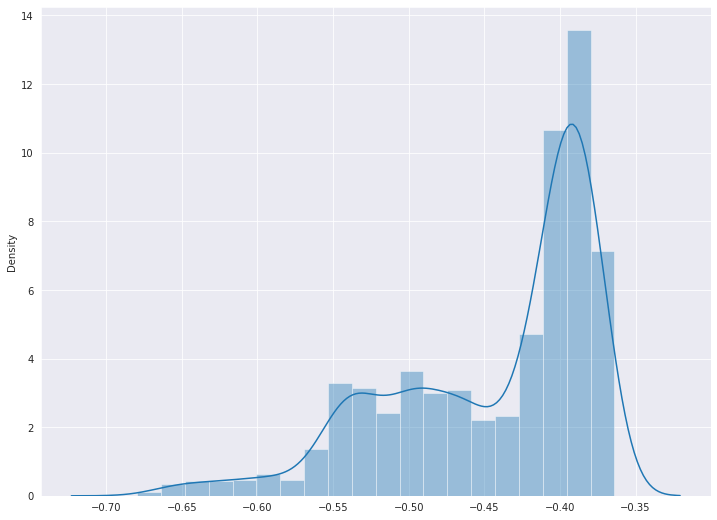

In [13]:
plt.rcParams["figure.figsize"] = (12,9)
sns.distplot(iso_score)
plt.show()

In [14]:
# SHAP Explainer
explainer = shap.TreeExplainer(iso,data=df4)
#Calculate shap with shap_values method
shap_values = explainer.shap_values(df4,check_additivity=True)
dfShap = pd.DataFrame(shap_values,columns=df4.columns,index=df4.index)

dfShap_temp = dfShap[:].copy()
dfShap_temp['ISO_SCORE'] = iso_score

 99%|===================| 2200/2222 [00:18<00:00]        

In [15]:
dfShap_temp

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
12    -0.012103      -0.088350         0.025876          0.018641   
13    -0.026510      -0.087224         0.028109          0.019842   
14    -0.162340      -0.123238        -0.456494         -0.307311   
3122  -0.219137      -0.070549        -0.414990         -0.484706   
3123  -0.081138      -0.028304         0.031349          0.028668   
...         ...            ...              ...               ...   
24849  0.041082       0.010405         0.053934          0.058986   
24850  0.077384       0.012552         0.049985          0.058279   
24851  0.077811       0.008970         0.055663          0.055415   
24852  0.026223       0.025181         0.055007          0.052462   
24853  0.052785       0.009832         0.054236          0.045252   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
12            -0.478003           -0.180047          -0.119031   
13            -0.523951           -0.137900          -0.119373   
14            -0.669673           -0.080452          -0.289446   
3122          -0.544768           -0.019483          -0.002374   
3123          -0.856408           -0.025548          -0.071046   
...                 ...                 ...                ...   
24849          0.052402            0.065732           0.031798   
24850          0.050517            0.060519           0.095206   
24851          0.049534            0.063708           0.063566   
24852          0.051519            0.061428           0.067136   
24853          0.047759            0.062109           0.119930   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_SCAV_AIR_PRESS  ...  \
12              -0.010177            -0.091245           -0.047133  ...   
13              -0.032718            -0.048192           -0.037715  ...   
14              -0.004768            -0.198592            0.055158  ...   
3122            -0.208438            -0.238747           -0.169710  ...   
3123            -0.388957            -0.032620           -0.041573  ...   
...                   ...                  ...                 ...  ...   
24849            0.105501             0.060437            0.215158  ...   
24850            0.075529            -0.038161            0.210066  ...   
24851            0.092479             0.052491            0.231484  ...   
24852            0.086857             0.073096            0.137821  ...   
24853            0.070401             0.060129            0.144157  ...   

       ME1_THRUST_PAD_TEMP  ME1_LO_INLET_PRESS  ME1_POWER   ME1_FOC  \
12               -0.218781           -0.009182  -0.157321 -0.115350   
13               -0.206367           -0.022383  -0.171833 -0.094661   
14               -0.303431            0.075991   0.029457 -0.044677   
3122             -0.189675           -0.173554  -0.154140 -0.201671   
3123             -0.109734            0.034923  -0.032888 -0.047717   
...                    ...                 ...        ...       ...   
24849             0.125099            0.174653   0.081433  0.091946   
24850             0.134070            0.171517   0.079167  0.075333   
24851             0.118772            0.084789   0.092561  0.076839   
24852             0.104861            0.161858   0.100496  0.075851   
24853             0.131513           -0.000629   0.110327  0.076414   

       TOTAL_WAVE_HEIGHT  WIND_SPEED  ME1_CYL_PCO_OUTLET_TEMP  \
12              0.039083   -0.048803                -0.016324   
13              0.044722    0.011215                -0.010316   
14              0.057433    0.010536                 0.056371   
3122           -0.095722    0.048103                -0.143243   
3123           -0.081353    0.062535                -0.004421   
...                  ...         ...                      ...   
24849           0.108954    0.094411                 0.139096   
24850           0.138236    0.108839                 0.140426   
24851           0.113970    0.098521           

In [16]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
uniqueSample = []


for item in list(dfShap_temp):
    dataFeatures.append(item)

for item in dataFeatures:
    dataType.append(dfShap_temp[item].dtype.name)
    
for item in dataFeatures:
    null.append(len(dfShap_temp[dfShap_temp[item].isnull() == True]))

for item in dataFeatures:
    nullPCT.append(round(len(dfShap_temp[dfShap_temp[item].isnull() == True])/len(dfShap_temp[item])*100,2))
    
for item in dataFeatures:
    minValue.append(dfShap_temp[item].min())

for item in dataFeatures:
    maxValue.append(dfShap_temp[item].max())

for item in dataFeatures:
    unique.append(dfShap_temp[item].nunique())

for item in dataFeatures:
    uniqueSample.append(dfShap_temp[item].unique()[0:2])

dfShap_temp_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
    'uniqueSample':uniqueSample
})
dfShap_temp_info

dataFeatures dataType  null  nullPCT  unique  minValue  \
0                       ME1_RPM  float64     0      0.0    2222 -0.592642   
1                 ME1_RPM_SHAFT  float64     0      0.0    2222 -0.275131   
2               ME1_SHAFT_POWER  float64     0      0.0    2222 -0.815180   
3              ME1_SHAFT_TORQUE  float64     0      0.0    2222 -0.801735   
4              ME1_SHAFT_THRUST  float64     0      0.0    2222 -0.861101   
5            ME1_FO_INLET_PRESS  float64     0      0.0    2222 -0.337281   
6             ME1_FO_INLET_TEMP  float64     0      0.0    2222 -0.760070   
7            ME1_JCW_INLET_TEMP  float64     0      0.0    2222 -0.530658   
8           ME1_JCW_INLET_PRESS  float64     0      0.0    2222 -0.991829   
9            ME1_SCAV_AIR_PRESS  float64     0      0.0    2222 -0.457164   
10            ME1_SCAV_AIR_TEMP  float64     0      0.0    2222 -0.495803   
11                     ME1_LOAD  float64     0      0.0    2222 -0.463663   
12                  ME1_TC1_RPM  float64     0      0.0    2222 -0.392333   
13                  ME1_TC2_RPM  float64     0      0.0    2222 -0.423684   
14            ME1_LO_INLET_TEMP  float64     0      0.0    2222 -0.987529   
15       ME1_TC1_LO_INLET_PRESS  float64     0      0.0    2222 -0.380134   
16       ME1_TC2_LO_INLET_PRESS  float64     0      0.0    2222 -0.479995   
17       ME1_TC1_LO_OUTLET_TEMP  float64     0      0.0    2222 -0.383419   
18       ME1_TC2_LO_OUTLET_TEMP  float64     0      0.0    2222 -0.356622   
19          ME1_THRUST_PAD_TEMP  float64     0      0.0    2222 -0.715677   
20           ME1_LO_INLET_PRESS  float64     0      0.0    2222 -1.200376   
21                    ME1_POWER  float64     0      0.0    2222 -0.304333   
22                      ME1_FOC  float64     0      0.0    2222 -0.406514   
23            TOTAL_WAVE_HEIGHT  float64     0      0.0    2222 -0.388387   
24                   WIND_SPEED  float64     0      0.0    2222 -0.599977   
25      ME1_CYL_PCO_OUTLET_TEMP  float64     0      0.0    2222 -0.414737   
26      ME1_CYL_CFW_OUTLET_TEMP  float64     0      0.0    2222 -0.688594   
27  ME1_CYL_EXH_GAS_OUTLET_TEMP  float64     0      0.0    2222 -0.357282   
28                    ISO_SCORE  float64     0      0.0    2220 -0.679589   

    maxValue                                    uniqueSample  
0   0.132743  [-0.012103232169465628, -0.026509827137633692]  
1   0.213121      [-0.088349877652945, -0.08722381500643678]  
2   0.059772     [0.02587571017560549, 0.028108907227870076]  
3   0.064351    [0.018640775023959576, 0.019842480844818055]  
4   0.059816     [-0.47800314432010055, -0.5239505019970239]  
5   0.106705     [-0.1800473421459901, -0.13789973194972846]  
6   0.120707    [-0.11903136766864918, -0.11937275360629428]  
7   0.116347    [-0.010177444368018769, -0.0327175919682486]  
8   0.100633    [-0.09124471373390407, -0.04819231115630828]  
9   0.279388    [-0.04713333489868091, -0.03771498585381778]  
10  0.166572     [-0.1732668154395651, -0.16324795889318922]  
11  0.189469      [-0.1574852892718627, -0.1553962197207147]  
12  0.148553     [-0.27839732475491474, -0.2740797954771551]  
13  0.138238     [-0.1601202140044188, -0.15469405338342768]  
14  0.105892      [-0.7756823457061546, -0.7764211933681509]  
15  0.120078     [-0.24794408525398468, -0.2385517034662189]  
16  0.166877    [-0.24204194737423676, -0.24022998600790743]  
17  0.205859      [-0.22619143977412023, -0.229227734504384]  
18  0.107198     [-0.1821949487022357, -0.14844372752588242]  
19  0.185537    [-0.21878094164916548, -0.20636705227690982]  
20  0.193256   [-0.009181601231102832, -0.02238253325864207]  
21  0.174692    [-0.15732100011548028, -0.17183347492245957]  
22  0.147554    [-0.11534981538366992, -0.09466062291583512]  
23  0.187852     [0.039083071367349474, 0.04472213578177616]  
24  0.135429   [-0.048803247320465745, 0.011214506076066754]  
25  0.179984  [-0.016324072978459298, -0.010316109450650401]  
26  0.1

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


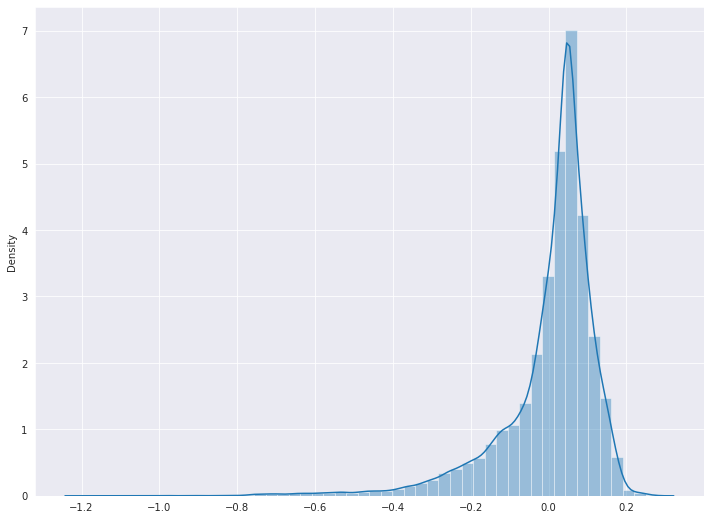

In [17]:
plt.rcParams["figure.figsize"] = (12,9)
sns.distplot(shap_values)
plt.show()

In [18]:
shap_values.max()

0.27938840524409897

In [19]:
shap_values.min()

-1.2003755468840245

In [20]:
dfShap

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
12    -0.012103      -0.088350         0.025876          0.018641   
13    -0.026510      -0.087224         0.028109          0.019842   
14    -0.162340      -0.123238        -0.456494         -0.307311   
3122  -0.219137      -0.070549        -0.414990         -0.484706   
3123  -0.081138      -0.028304         0.031349          0.028668   
...         ...            ...              ...               ...   
24849  0.041082       0.010405         0.053934          0.058986   
24850  0.077384       0.012552         0.049985          0.058279   
24851  0.077811       0.008970         0.055663          0.055415   
24852  0.026223       0.025181         0.055007          0.052462   
24853  0.052785       0.009832         0.054236          0.045252   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
12            -0.478003           -0.180047          -0.119031   
13            -0.523951           -0.137900          -0.119373   
14            -0.669673           -0.080452          -0.289446   
3122          -0.544768           -0.019483          -0.002374   
3123          -0.856408           -0.025548          -0.071046   
...                 ...                 ...                ...   
24849          0.052402            0.065732           0.031798   
24850          0.050517            0.060519           0.095206   
24851          0.049534            0.063708           0.063566   
24852          0.051519            0.061428           0.067136   
24853          0.047759            0.062109           0.119930   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_SCAV_AIR_PRESS  ...  \
12              -0.010177            -0.091245           -0.047133  ...   
13              -0.032718            -0.048192           -0.037715  ...   
14              -0.004768            -0.198592            0.055158  ...   
3122            -0.208438            -0.238747           -0.169710  ...   
3123            -0.388957            -0.032620           -0.041573  ...   
...                   ...                  ...                 ...  ...   
24849            0.105501             0.060437            0.215158  ...   
24850            0.075529            -0.038161            0.210066  ...   
24851            0.092479             0.052491            0.231484  ...   
24852            0.086857             0.073096            0.137821  ...   
24853            0.070401             0.060129            0.144157  ...   

       ME1_TC2_LO_OUTLET_TEMP  ME1_THRUST_PAD_TEMP  ME1_LO_INLET_PRESS  \
12                  -0.182195            -0.218781           -0.009182   
13                  -0.148444            -0.206367           -0.022383   
14                  -0.042113            -0.303431            0.075991   
3122                -0.147965            -0.189675           -0.173554   
3123                -0.057780            -0.109734            0.034923   
...                       ...                  ...                 ...   
24849                0.060906             0.125099            0.174653   
24850                0.062895             0.134070            0.171517   
24851                0.068543             0.118772            0.084789   
24852                0.052319             0.104861            0.161858   
24853                0.071021             0.131513           -0.000629   

       ME1_POWER   ME1_FOC  TOTAL_WAVE_HEIGHT  WIND_SPEED  \
12     -0.157321 -0.115350           0.039083   -0.048803   
13     -0.171833 -0.094661           0.044722    0.011215   
14      0.029457 -0.044677           0.057433    0.010536   
3122   -0.154140 -0.201671          -0.095722    0.048103   
3123   -0.032888 -0.047717          -0.081353    0.062535   
...          ...       ...                ...         ...   
24849   0.081433  0.091946           0.108954    0.094411   
24850   0.079167  0.075333           0.138236    0.108839   
24851   0.092561  0.076839           0.113970  

In [21]:
df3.columns

Index(['ME1_RPM', 'ME1_RPM_SHAFT', 'ME1_SHAFT_POWER', 'ME1_SHAFT_TORQUE',
       'ME1_SHAFT_THRUST', 'ME1_FO_INLET_PRESS', 'ME1_FO_INLET_TEMP',
       'ME1_JCW_INLET_TEMP', 'ME1_JCW_INLET_PRESS', 'ME1_SCAV_AIR_PRESS',
       'ME1_SCAV_AIR_TEMP', 'ME1_LOAD', 'ME1_TC1_RPM', 'ME1_TC2_RPM',
       'ME1_LO_INLET_TEMP', 'ME1_TC1_LO_INLET_PRESS', 'ME1_TC2_LO_INLET_PRESS',
       'ME1_TC1_LO_OUTLET_TEMP', 'ME1_TC2_LO_OUTLET_TEMP',
       'ME1_THRUST_PAD_TEMP', 'ME1_LO_INLET_PRESS', 'ME1_POWER', 'ME1_FOC',
       'TOTAL_WAVE_HEIGHT', 'WIND_SPEED', 'SPEED_VG', 'lon', 'lat',
       'TIME_STAMP', 'ME1_CYL_PCO_OUTLET_TEMP', 'ME1_CYL_CFW_OUTLET_TEMP',
       'ME1_CYL_EXH_GAS_OUTLET_TEMP'],
      dtype='object')

In [22]:
dfShap.columns

Index(['ME1_RPM', 'ME1_RPM_SHAFT', 'ME1_SHAFT_POWER', 'ME1_SHAFT_TORQUE',
       'ME1_SHAFT_THRUST', 'ME1_FO_INLET_PRESS', 'ME1_FO_INLET_TEMP',
       'ME1_JCW_INLET_TEMP', 'ME1_JCW_INLET_PRESS', 'ME1_SCAV_AIR_PRESS',
       'ME1_SCAV_AIR_TEMP', 'ME1_LOAD', 'ME1_TC1_RPM', 'ME1_TC2_RPM',
       'ME1_LO_INLET_TEMP', 'ME1_TC1_LO_INLET_PRESS', 'ME1_TC2_LO_INLET_PRESS',
       'ME1_TC1_LO_OUTLET_TEMP', 'ME1_TC2_LO_OUTLET_TEMP',
       'ME1_THRUST_PAD_TEMP', 'ME1_LO_INLET_PRESS', 'ME1_POWER', 'ME1_FOC',
       'TOTAL_WAVE_HEIGHT', 'WIND_SPEED', 'ME1_CYL_PCO_OUTLET_TEMP',
       'ME1_CYL_CFW_OUTLET_TEMP', 'ME1_CYL_EXH_GAS_OUTLET_TEMP'],
      dtype='object')

<Figure size 1080x1080 with 0 Axes>

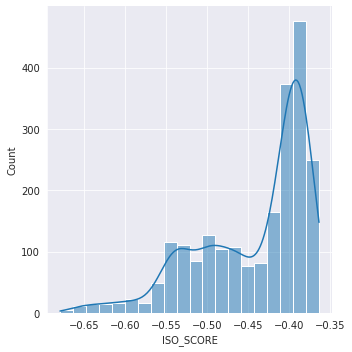

In [23]:
plt.figure(figsize=(15,15))
sns.displot(dfShap_temp['ISO_SCORE'], kde=True)

In [24]:
print('df4 - MAX ISO_SCORE index: ' + str(dfShap_temp['ISO_SCORE'].idxmax(axis=0)))
print('df4 - MIN ISO_SCORE index: ' + str(dfShap_temp['ISO_SCORE'].idxmin(axis=0)))

dfShap_temp2 = dfShap_temp[:].copy()
dfShap_temp2.reset_index(drop=True,inplace=True)
print()
print('shap_values - MAX ISO_SCORE index: ' + str(dfShap_temp2['ISO_SCORE'].idxmax(axis=0)))
print('shap values - MIN ISO_SCORE index: ' + str(dfShap_temp2['ISO_SCORE'].idxmin(axis=0)))

df4 - MAX ISO_SCORE index: 23490
df4 - MIN ISO_SCORE index: 5285

shap_values - MAX ISO_SCORE index: 1368
shap values - MIN ISO_SCORE index: 84


In [25]:
# MAX ISO_SCORE FORCE PLOT
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1379], df4.loc[23501])

In [26]:
# MIN ISO_SCORE FORCE PLOT
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[84], df4.loc[5285])

In [27]:
# TOTAL ISO_SCORE FORCE PLOT
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, df4)

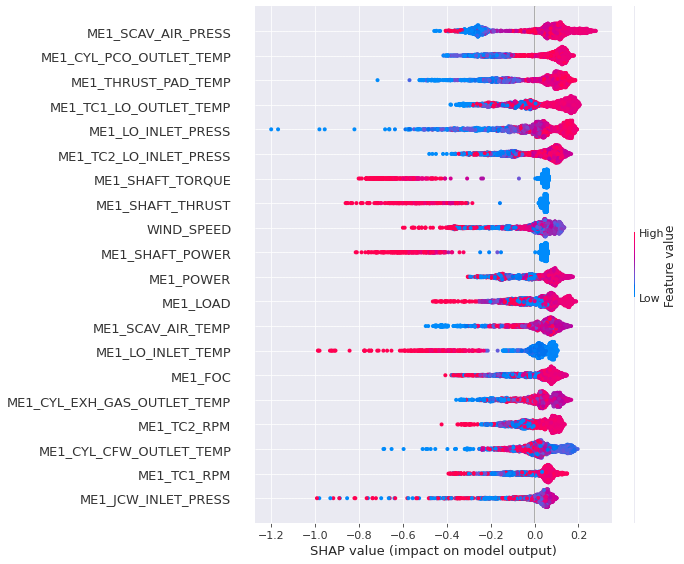

In [28]:
shap.initjs()
shap.summary_plot(shap_values, df4)

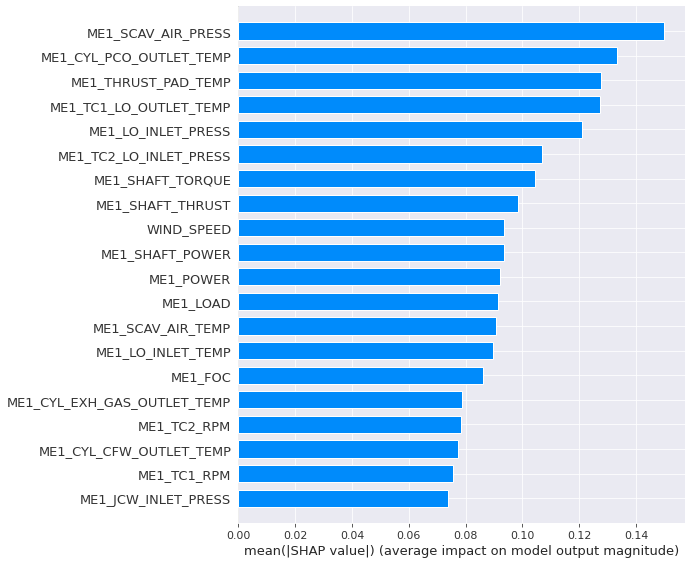

In [29]:
shap.initjs()
shap.summary_plot(shap_values, df4, plot_type='bar')

In [30]:
dfShap_temp['ISO_SCORE'].describe()

count    2222.000000
mean       -0.443343
std         0.067652
min        -0.679589
25%        -0.493573
50%        -0.412239
75%        -0.390467
max        -0.363980
Name: ISO_SCORE, dtype: float64

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='ISO_SCORE'>

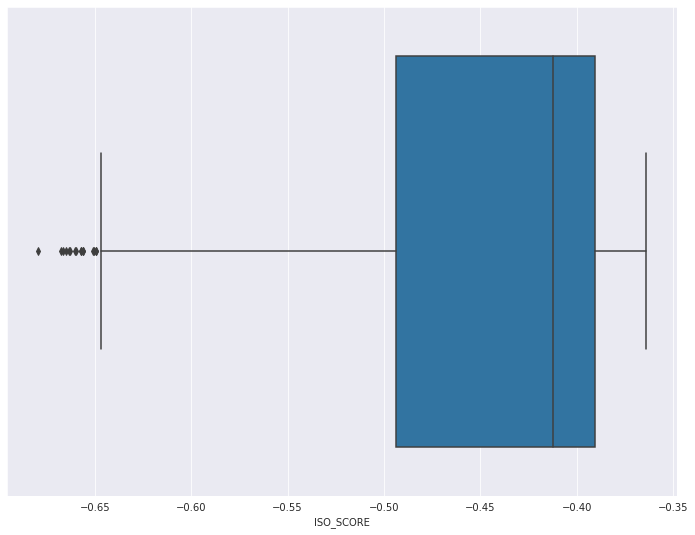

In [31]:
sns.boxplot(dfShap_temp['ISO_SCORE'])

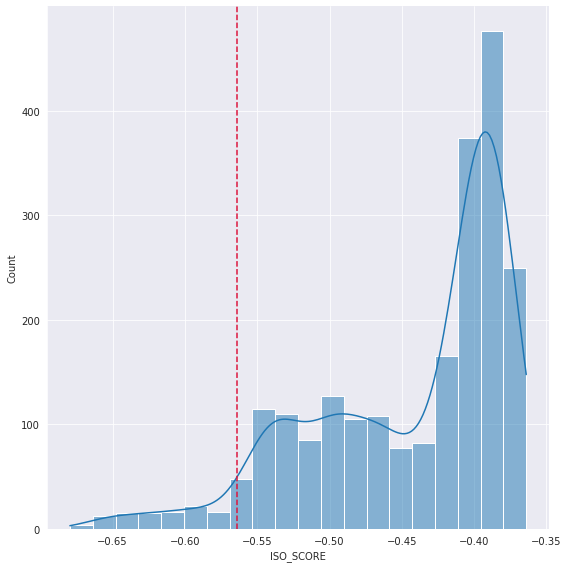

In [32]:
sns.displot(dfShap_temp['ISO_SCORE'],kde=True, height=8)
plt.axvline(np.quantile(dfShap_temp['ISO_SCORE'],0.05), color='crimson', linestyle='--'); 

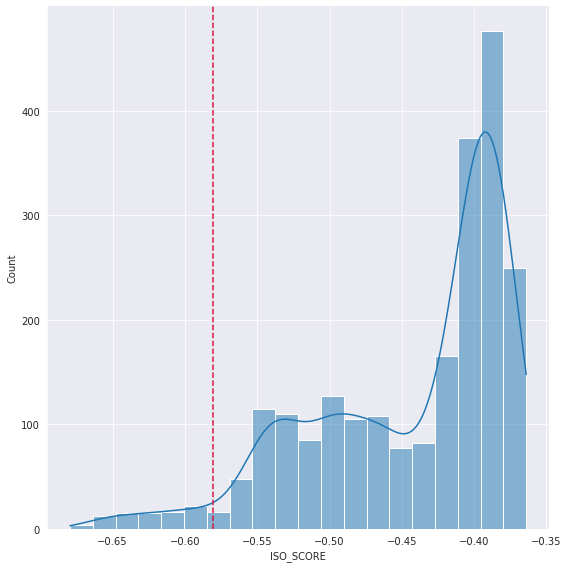

In [33]:
sns.displot(dfShap_temp['ISO_SCORE'],kde=True, height=8)
plt.axvline(np.quantile(dfShap_temp['ISO_SCORE'],0.04), color='crimson', linestyle='--'); 

In [34]:
np.quantile(dfShap_temp['ISO_SCORE'],0.05)

-0.5639123632268502

In [35]:
np.quantile(dfShap_temp['ISO_SCORE'],0.04)

-0.5806713273362981

Text(0, 0.5, 'Distance')

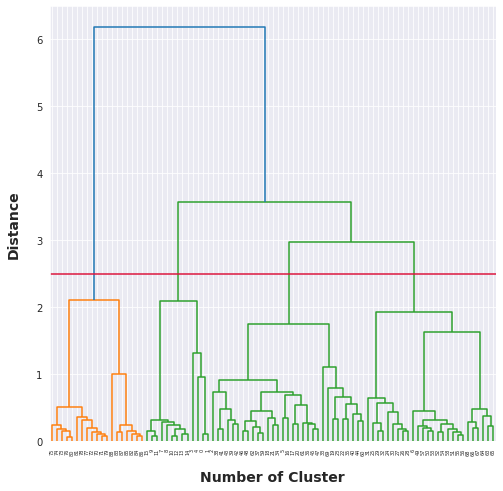

In [36]:
fixed_th = np.quantile(dfShap_temp['ISO_SCORE'],0.04)
dfShap_temp1 = dfShap_temp[dfShap_temp['ISO_SCORE'] <= fixed_th].drop(['ISO_SCORE'],axis=1)
dfShap_temp2 = dfShap_temp[dfShap_temp['ISO_SCORE'] > fixed_th].drop(['ISO_SCORE'],axis=1)

clusters = hierarchy.linkage(dfShap_temp1, method="ward")
plt.figure(figsize=(8, 8))
dendrogram = hierarchy.dendrogram(clusters)
plt.axhline(2.5, color='crimson');
plt.xlabel("Number of Cluster", labelpad=15, weight='bold', size=14)
plt.ylabel("Distance", labelpad=15, weight='bold', size=14)

In [37]:
clustering_model = AgglomerativeClustering(n_clusters=5, linkage="ward")
clustering_model.fit(dfShap_temp1)
labels = clustering_model.labels_

dfShap_temp1['CLUSTER'] = labels
dfShap_temp2['CLUSTER'] = np.nan
dfShap = pd.concat([dfShap_temp1, dfShap_temp2])

In [38]:
dfShap['CLUSTER'].unique()

array([ 0.,  3.,  1.,  4.,  2., nan])

In [39]:
dfShap[dfShap['CLUSTER'].notnull()]

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
12    -0.012103      -0.088350         0.025876          0.018641   
13    -0.026510      -0.087224         0.028109          0.019842   
3122  -0.219137      -0.070549        -0.414990         -0.484706   
3128  -0.046299      -0.107683        -0.495145         -0.538477   
3133  -0.305730      -0.063821         0.023653          0.030006   
...         ...            ...              ...               ...   
20648 -0.112827      -0.018628         0.029851          0.029523   
20649 -0.091820      -0.011593         0.029968          0.028207   
20650 -0.083710      -0.028668         0.028825          0.029762   
20654 -0.094885       0.001182         0.029913          0.029617   
24007 -0.015488      -0.031909         0.022302          0.021953   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
12            -0.478003           -0.180047          -0.119031   
13            -0.523951           -0.137900          -0.119373   
3122          -0.544768           -0.019483          -0.002374   
3128          -0.650542           -0.040974          -0.010271   
3133          -0.713526           -0.069662           0.008973   
...                 ...                 ...                ...   
20648          0.025290           -0.062650          -0.164330   
20649          0.024017           -0.041257          -0.203881   
20650          0.024157           -0.046346          -0.176038   
20654          0.023846           -0.031583          -0.184828   
24007          0.018258           -0.179227          -0.178474   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_SCAV_AIR_PRESS  ...  \
12              -0.010177            -0.091245           -0.047133  ...   
13              -0.032718            -0.048192           -0.037715  ...   
3122            -0.208438            -0.238747           -0.169710  ...   
3128            -0.339435            -0.432224            0.083234  ...   
3133            -0.530658            -0.203308           -0.219796  ...   
...                   ...                  ...                 ...  ...   
20648           -0.217042            -0.172223           -0.318351  ...   
20649           -0.204428            -0.285639           -0.332705  ...   
20650           -0.204944            -0.202838           -0.317560  ...   
20654           -0.232101            -0.073136           -0.327700  ...   
24007           -0.272129             0.034852           -0.400939  ...   

       ME1_THRUST_PAD_TEMP  ME1_LO_INLET_PRESS  ME1_POWER   ME1_FOC  \
12               -0.218781           -0.009182  -0.157321 -0.115350   
13               -0.206367           -0.022383  -0.171833 -0.094661   
3122             -0.189675           -0.173554  -0.154140 -0.201671   
3128             -0.001771            0.039589   0.028852 -0.042387   
3133             -0.041407           -0.025009  -0.185758 -0.266198   
...                    ...                 ...        ...       ...   
20648            -0.294783           -0.001804  -0.250251 -0.305549   
20649            -0.290941           -0.039797  -0.260965 -0.321093   
20650            -0.301818           -0.017315  -0.243796 -0.317788   
20654            -0.258173           -0.043409  -0.238229 -0.263880   
24007            -0.086039            0.042367  -0.263927 -0.406514   

       TOTAL_WAVE_HEIGHT  WIND_SPEED  ME1_CYL_PCO_OUTLET_TEMP  \
12              0.039083   -0.048803                -0.016324   
13              0.044722    0.011215                -0.010316   
3122           -0.095722    0.048103                -0.143243   
3128           -0.081937    0.055443                -0.041478   
3133           -0.098758    0.054364                -0.046155   
...                  ...         ...                      ...   
20648          -0.104008    0.020189                -0.303826   
20649          -0.132587    0.019841                -0.323310   
20650          -0.105220    0.021862           

In [40]:
dfShap

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
12    -0.012103      -0.088350         0.025876          0.018641   
13    -0.026510      -0.087224         0.028109          0.019842   
3122  -0.219137      -0.070549        -0.414990         -0.484706   
3128  -0.046299      -0.107683        -0.495145         -0.538477   
3133  -0.305730      -0.063821         0.023653          0.030006   
...         ...            ...              ...               ...   
24849  0.041082       0.010405         0.053934          0.058986   
24850  0.077384       0.012552         0.049985          0.058279   
24851  0.077811       0.008970         0.055663          0.055415   
24852  0.026223       0.025181         0.055007          0.052462   
24853  0.052785       0.009832         0.054236          0.045252   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
12            -0.478003           -0.180047          -0.119031   
13            -0.523951           -0.137900          -0.119373   
3122          -0.544768           -0.019483          -0.002374   
3128          -0.650542           -0.040974          -0.010271   
3133          -0.713526           -0.069662           0.008973   
...                 ...                 ...                ...   
24849          0.052402            0.065732           0.031798   
24850          0.050517            0.060519           0.095206   
24851          0.049534            0.063708           0.063566   
24852          0.051519            0.061428           0.067136   
24853          0.047759            0.062109           0.119930   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_SCAV_AIR_PRESS  ...  \
12              -0.010177            -0.091245           -0.047133  ...   
13              -0.032718            -0.048192           -0.037715  ...   
3122            -0.208438            -0.238747           -0.169710  ...   
3128            -0.339435            -0.432224            0.083234  ...   
3133            -0.530658            -0.203308           -0.219796  ...   
...                   ...                  ...                 ...  ...   
24849            0.105501             0.060437            0.215158  ...   
24850            0.075529            -0.038161            0.210066  ...   
24851            0.092479             0.052491            0.231484  ...   
24852            0.086857             0.073096            0.137821  ...   
24853            0.070401             0.060129            0.144157  ...   

       ME1_THRUST_PAD_TEMP  ME1_LO_INLET_PRESS  ME1_POWER   ME1_FOC  \
12               -0.218781           -0.009182  -0.157321 -0.115350   
13               -0.206367           -0.022383  -0.171833 -0.094661   
3122             -0.189675           -0.173554  -0.154140 -0.201671   
3128             -0.001771            0.039589   0.028852 -0.042387   
3133             -0.041407           -0.025009  -0.185758 -0.266198   
...                    ...                 ...        ...       ...   
24849             0.125099            0.174653   0.081433  0.091946   
24850             0.134070            0.171517   0.079167  0.075333   
24851             0.118772            0.084789   0.092561  0.076839   
24852             0.104861            0.161858   0.100496  0.075851   
24853             0.131513           -0.000629   0.110327  0.076414   

       TOTAL_WAVE_HEIGHT  WIND_SPEED  ME1_CYL_PCO_OUTLET_TEMP  \
12              0.039083   -0.048803                -0.016324   
13              0.044722    0.011215                -0.010316   
3122           -0.095722    0.048103                -0.143243   
3128           -0.081937    0.055443                -0.041478   
3133           -0.098758    0.054364                -0.046155   
...                  ...         ...                      ...   
24849           0.108954    0.094411                 0.139096   
24850           0.138236    0.108839                 0.140426   
24851           0.113970    0.098521           

In [41]:
dfShap['TOTAL_WAVE_HEIGHT'] = df3['TOTAL_WAVE_HEIGHT']
dfShap['WIND_SPEED'] = df3['WIND_SPEED']

In [42]:
dfShap['CLUSTER'].unique()

array([ 0.,  3.,  1.,  4.,  2., nan])

In [43]:
df['TOTAL_WAVE_HEIGHT'].describe()

count    24854.000000
mean         1.526378
std          0.952908
min          0.100000
25%          0.760000
50%          1.380000
75%          2.220000
max          6.340000
Name: TOTAL_WAVE_HEIGHT, dtype: float64

In [44]:
dfShap['TOTAL_WAVE_HEIGHT'].describe()

count    2222.000000
mean        1.667390
std         0.986394
min         0.110000
25%         0.570000
50%         2.010000
75%         2.520000
max         4.000000
Name: TOTAL_WAVE_HEIGHT, dtype: float64

In [56]:
dfShap[dfShap['CLUSTER'] == 2.]['ME1_RPM'].describe()

count    7.000000
mean    -0.085202
std      0.033430
min     -0.115727
25%     -0.103856
50%     -0.091820
75%     -0.082833
max     -0.015488
Name: ME1_RPM, dtype: float64

In [55]:
dfShap[dfShap['CLUSTER'] == 3.]['ME1_RPM'].describe()

count    31.000000
mean     -0.243200
std       0.064561
min      -0.377266
25%      -0.288165
50%      -0.262861
75%      -0.194938
max      -0.108847
Name: ME1_RPM, dtype: float64

In [50]:
dfShap[dfShap['CLUSTER'] == 3.]['TOTAL_WAVE_HEIGHT'].describe()

count    31.000000
mean      1.664839
std       0.640525
min       0.320000
25%       1.295000
50%       1.800000
75%       2.080000
max       2.940000
Name: TOTAL_WAVE_HEIGHT, dtype: float64

In [51]:
df['WIND_SPEED'].describe()

count    24854.000000
mean         6.108298
std          2.708944
min          0.030000
25%          4.010000
50%          5.800000
75%          8.090000
max         15.610000
Name: WIND_SPEED, dtype: float64

In [53]:
dfShap['WIND_SPEED'].describe()

count    2222.000000
mean        6.075189
std         2.534824
min         0.220000
25%         4.192500
50%         5.900000
75%         8.080000
max        13.410000
Name: WIND_SPEED, dtype: float64

In [52]:
dfShap[dfShap['CLUSTER'] == 3.]['WIND_SPEED'].describe()

count    31.000000
mean      5.907097
std       2.325586
min       1.720000
25%       4.560000
50%       5.940000
75%       7.495000
max      11.120000
Name: WIND_SPEED, dtype: float64

In [ ]:
dfShap[dfShap['CLUSTER'] == 3.]['TOTAL_WAVE_HEIGHT'].describe()

In [ ]:
dfShap[dfShap['CLUSTER'] == 4.]['TOTAL_WAVE_HEIGHT'].describe()

In [26]:
# datamart creation
datamart = df3.join(dfShap, rsuffix='_SHAP') 
datamart['ISO_SCORE'] = iso_score
datamart = datamart[datamart.columns.difference(df2.columns)]


datamart = df2.join(datamart)
datamart['INGESTION_DT'] = dff['TIME_STAMP']

In [27]:
datamart

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
0       51.060           50.9              0.0               0.0   
1       50.970           50.9              0.0               0.0   
2       51.120           50.9              0.0               0.0   
3       54.042           50.9              0.0               0.0   
4       56.376           50.9              0.0               0.0   
...        ...            ...              ...               ...   
24849   58.710            0.0              0.0               0.0   
24850   58.700            0.0              0.0               0.0   
24851   58.610            0.0              0.0               0.0   
24852   58.790            0.0              0.0               0.0   
24853   58.760            0.0              0.0               0.0   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
0                2220.0               7.686            134.763   
1                2220.0               7.687            133.605   
2                2220.0               7.697            135.074   
3                2220.0               7.637            135.089   
4                2220.0               7.593            135.735   
...                 ...                 ...                ...   
24849               0.0               7.586            129.080   
24850               0.0               7.580            130.014   
24851               0.0               7.583            129.519   
24852               0.0               7.584            129.094   
24853               0.0               7.580            129.884   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_CYL1_CFW_OUTLET_TEMP  ...  \
0                  78.115                4.352                   119.036  ...   
1                  77.957                4.340                   119.012  ...   
2                  78.249                4.356                   119.076  ...   
3                  77.434                4.355                   118.808  ...   
4                  77.107                4.355                   117.144  ...   
...                   ...                  ...                       ...  ...   
24849              77.480                4.409                   116.357  ...   
24850              77.366                4.368                   116.399  ...   
24851              77.453                4.387                   116.218  ...   
24852              77.460                4.411                   116.221  ...   
24853              77.299                4.392                   115.949  ...   

       ME1_SHAFT_THRUST_SHAP  ME1_SHAFT_TORQUE_SHAP  \
0                        NaN                    NaN   
1                        NaN                    NaN   
2                        NaN                    NaN   
3                        NaN                    NaN   
4                        NaN                    NaN   
...                      ...                    ...   
24849               0.056997               0.057469   
24850               0.055084               0.044884   
24851               0.057474               0.052427   
24852               0.052301               0.052956   
24853               0.053432               0.053647   

       ME1_TC1_LO_INLET_PRESS_SHAP  ME1_TC1_LO_OUTLET_TEMP_SHAP  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
24849                     0.108581                     0.102386   
24850                     0.118282                     0.108762   
24851                     0.153193                     0.106494   
24852                     0.103637                     0.112392   
24853                     

In [120]:
# datamart.to_csv("datamart.csv", encoding='utf-8', index=False, na_rep='NaN')

In [125]:
# datamart[datamart['CLUSTER'].notnull()].to_csv("anomalies.csv", encoding='utf-8', index=True, index_label='index', na_rep='NaN',)

In [97]:
datamart.columns

Index(['ME1_RPM', 'ME1_RPM_SHAFT', 'ME1_SHAFT_POWER', 'ME1_SHAFT_TORQUE',
       'ME1_SHAFT_THRUST', 'ME1_FO_INLET_PRESS', 'ME1_FO_INLET_TEMP',
       'ME1_JCW_INLET_TEMP', 'ME1_JCW_INLET_PRESS', 'ME1_CYL1_CFW_OUTLET_TEMP',
       'ME1_CYL2_CFW_OUTLET_TEMP', 'ME1_CYL3_CFW_OUTLET_TEMP',
       'ME1_CYL4_CFW_OUTLET_TEMP', 'ME1_CYL5_CFW_OUTLET_TEMP',
       'ME1_CYL6_CFW_OUTLET_TEMP', 'ME1_CYL7_CFW_OUTLET_TEMP',
       'ME1_SCAV_AIR_PRESS', 'ME1_SCAV_AIR_TEMP', 'ME1_CYL1_PCO_OUTLET_TEMP',
       'ME1_CYL2_PCO_OUTLET_TEMP', 'ME1_CYL3_PCO_OUTLET_TEMP',
       'ME1_CYL4_PCO_OUTLET_TEMP', 'ME1_CYL5_PCO_OUTLET_TEMP',
       'ME1_CYL6_PCO_OUTLET_TEMP', 'ME1_CYL7_PCO_OUTLET_TEMP',
       'ME1_TC1_EXH_INLET_TEMP', 'ME1_TC2_EXH_INLET_TEMP',
       'ME1_TC1_EXH_OUTLET_TEMP', 'ME1_TC2_EXH_OUTLET_TEMP', 'ME1_LOAD',
       'ME1_TC1_RPM', 'ME1_TC2_RPM', 'ME1_LO_INLET_TEMP',
       'ME1_TC1_LO_INLET_PRESS', 'ME1_TC2_LO_INLET_PRESS',
       'ME1_TC1_LO_OUTLET_TEMP', 'ME1_TC2_LO_OUTLET_TEMP',
       'ME1_

In [28]:
datamart['CLUSTER'].unique()

array([nan,  0.,  2.,  1.,  4.,  3.])

In [56]:
datamart_temp = datamart.copy()
datamart_temp.loc[(datamart_temp.CLUSTER == 0), 'CLUSTER']='CLUSTER 1'
datamart_temp.loc[(datamart_temp.CLUSTER == 1), 'CLUSTER']='CLUSTER 2'
datamart_temp.loc[(datamart_temp.CLUSTER == 2), 'CLUSTER']='CLUSTER 3'
datamart_temp.loc[(datamart_temp.CLUSTER == 3), 'CLUSTER']='CLUSTER 4'
datamart_temp.loc[(datamart_temp.CLUSTER == 4), 'CLUSTER']='CLUSTER 5'

In [57]:
datamart_temp['CLUSTER'].unique()

array([nan, 'CLUSTER 1', 'CLUSTER 3', 'CLUSTER 2', 'CLUSTER 5',
       'CLUSTER 4'], dtype=object)

In [58]:
len(datamart_temp[datamart_temp['CLUSTER'].notnull()])

89

In [119]:
datamart_temp[datamart_temp['CLUSTER'].notnull()]

ME1_RPM  ME1_RPM_SHAFT  ME1_SHAFT_POWER  ME1_SHAFT_TORQUE  \
12      58.595         58.800             0.00             0.000   
13      58.510         58.800             0.00             0.000   
3122    55.073         55.163         11596.60          2007.000   
3133    56.325         58.700             0.00             0.000   
3407    53.967         53.152           900.81           162.155   
...        ...            ...              ...               ...   
20464   52.960         52.977             0.00             0.000   
20644   52.964         52.997             0.00             0.000   
20646   52.922         52.981             0.00             0.000   
20649   53.080         52.983             0.00             0.000   
24113   58.590          0.000             0.00             0.000   

       ME1_SHAFT_THRUST  ME1_FO_INLET_PRESS  ME1_FO_INLET_TEMP  \
12             2220.000               7.558            133.618   
13             2220.000               7.562            133.613   
3122           2220.000               7.664            131.729   
3133           2220.000               7.677            132.150   
3407           1218.121               7.684            132.132   
...                 ...                 ...                ...   
20464             0.000               7.698             48.050   
20644             0.000               7.706            135.243   
20646             0.000               7.712            135.498   
20649             0.000               7.709            135.594   
24113             0.000               7.564            127.280   

       ME1_JCW_INLET_TEMP  ME1_JCW_INLET_PRESS  ME1_CYL1_CFW_OUTLET_TEMP  ...  \
12                 77.014                4.348                   115.592  ...   
13                 76.993                4.357                   115.577  ...   
3122               78.445                4.326                   118.798  ...   
3133               78.856                4.336                   117.587  ...   
3407               78.121                4.353                   119.002  ...   
...                   ...                  ...                       ...  ...   
20464              78.765                4.328                   118.656  ...   
20644              78.794                4.342                   118.647  ...   
20646              78.760                4.347                   118.609  ...   
20649              78.789                4.326                   118.638  ...   
24113              76.898                4.391                   114.474  ...   

       ME1_SHAFT_THRUST_SHAP  ME1_SHAFT_TORQUE_SHAP  \
12                 -0.798561               0.018965   
13                 -0.772257               0.018539   
3122               -0.686102              -0.578823   
3133               -0.757204               0.038548   
3407               -0.759618              -0.029944   
...                      ...                    ...   
20464               0.037475               0.031783   
20644               0.036002               0.032171   
20646               0.036156               0.031554   
20649               0.035428               0.030955   
24113               0.034424               0.020973   

       ME1_TC1_LO_INLET_PRESS_SHAP  ME1_TC1_LO_OUTLET_TEMP_SHAP  \
12                       -0.253547                    -0.290092   
13                       -0.248122                    -0.272709   
3122                     -0.108398                    -0.224979   
3133                     -0.063387                    -0.099992   
3407                     -0.171901                    -0.164890   
...                            ...                          ...   
20464                    -0.148237                    -0.227578   
20644                    -0.154045                    -0.310008   
20646                    -0.153936                    -0.298940   
20649                    -0.140921                    -0.311114   
24113                    -

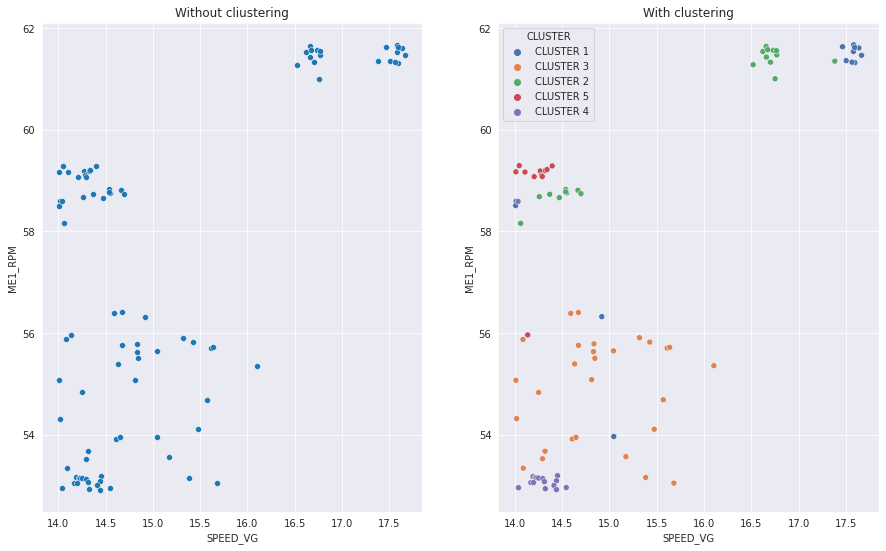

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,9))

sns.scatterplot(ax=axes[0], data=datamart_temp[datamart_temp['CLUSTER'].notnull()], x='SPEED_VG', y='ME1_RPM').set_title('Without cliustering')
sns.scatterplot(ax=axes[1], data=datamart_temp[datamart_temp['CLUSTER'].notnull()], x='SPEED_VG', y='ME1_RPM', hue='CLUSTER',palette='deep').set_title('With clustering')

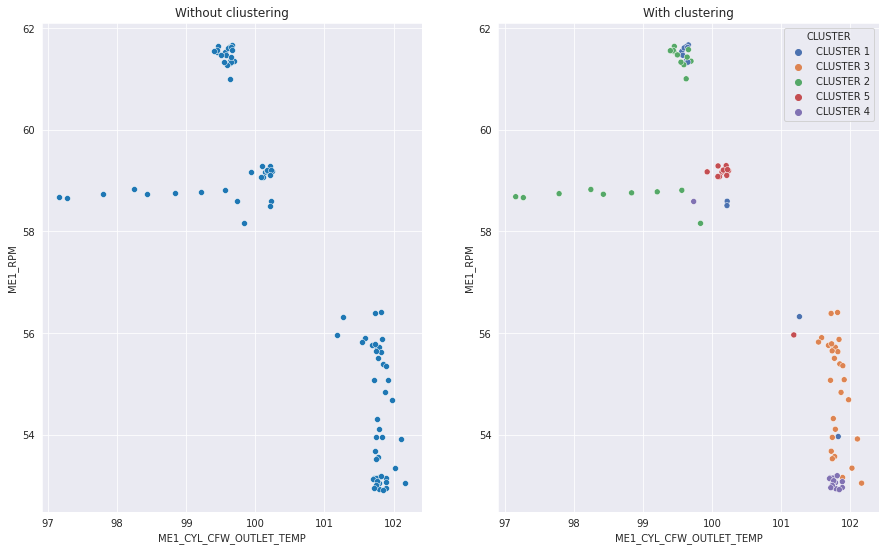

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,9))

sns.scatterplot(ax=axes[0], data=datamart_temp[datamart_temp['CLUSTER'].notnull()], x='ME1_CYL_CFW_OUTLET_TEMP', y='ME1_RPM').set_title('Without cliustering')
sns.scatterplot(ax=axes[1], data=datamart_temp[datamart_temp['CLUSTER'].notnull()], x='ME1_CYL_CFW_OUTLET_TEMP', y='ME1_RPM', hue='CLUSTER',palette='deep').set_title('With clustering')

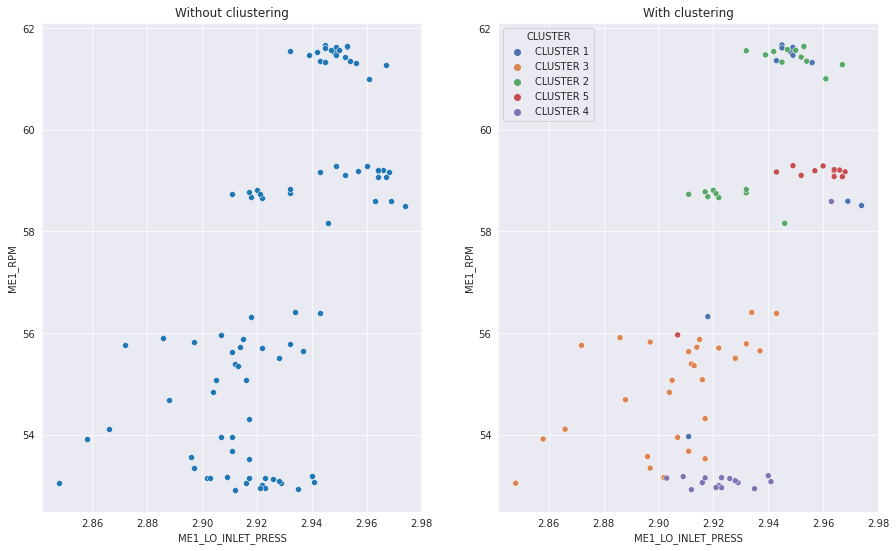

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,9))

sns.scatterplot(ax=axes[0], data=datamart_temp[datamart_temp['CLUSTER'].notnull()], x='ME1_LO_INLET_PRESS', y='ME1_RPM').set_title('Without cliustering')
sns.scatterplot(ax=axes[1], data=datamart_temp[datamart_temp['CLUSTER'].notnull()], x='ME1_LO_INLET_PRESS', y='ME1_RPM', hue='CLUSTER',palette='deep').set_title('With clustering')